In [1]:
import urllib.request
from pyspark.sql import SparkSession

# Download the CSV file
url = "https://raw.githubusercontent.com/owid/covid-19-data/refs/heads/master/public/data/owid-covid-data.csv"
local_filename = "owid-covid-data.csv"
urllib.request.urlretrieve(url, local_filename)

# Initialize Spark session
spark = SparkSession.builder.appName("COVID19").getOrCreate()

In [2]:
# Charger le dataset COVID-19
df = spark.read.option("header", "true").option("inferSchema", "true").csv(local_filename)

# Afficher la structure du DataFrame
print("Schema du dataset :")
df.printSchema()

# Afficher les dimensions
print(f"\nNombre de lignes : {df.count()}")
print(f"Nombre de colonnes : {len(df.columns)}")

# Afficher les premières lignes
print("\nAperçu des données :")
df.show(5)

Schema du dataset :
root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: integer (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: integer (nullable = true)
 |-- h

In [3]:
from pyspark.sql.functions import col, isnan, when, count, sum as spark_sum, desc, asc
from pyspark.sql.functions import min as spark_min, max as spark_max

# 1. Analyser les valeurs manquantes par colonne
print("=== ANALYSE DES VALEURS MANQUANTES ===")
missing_data = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).collect()[0].asDict()

# Afficher les colonnes avec le plus de valeurs manquantes
missing_sorted = sorted(missing_data.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 des colonnes avec le plus de valeurs manquantes :")
for col_name, missing_count in missing_sorted[:10]:
    percentage = (missing_count / df.count()) * 100
    print(f"{col_name}: {missing_count:,} ({percentage:.1f}%)")

# 2. Analyser la période temporelle
print("\n=== ANALYSE TEMPORELLE ===")
date_range = df.select(
    spark_min("date").alias("date_debut"),
    spark_max("date").alias("date_fin")
).collect()[0]

print(f"Période couverte : {date_range['date_debut']} à {date_range['date_fin']}")

# 3. Analyser la couverture géographique
print("\n=== ANALYSE GÉOGRAPHIQUE ===")
geo_stats = df.select("continent", "location").distinct()
print(f"Nombre de pays/territoires : {geo_stats.count()}")

continents = df.select("continent").distinct().filter(col("continent").isNotNull())
print(f"Continents représentés : {continents.count()}")
continents.show()

# 4. Examiner quelques lignes avec des données complètes
print("\n=== ÉCHANTILLON DE DONNÉES RÉCENTES ===")
df.filter(
    (col("total_cases") > 0) & 
    (col("date") >= "2023-01-01")
).select(
    "location", "date", "total_cases", "total_deaths", 
    "people_fully_vaccinated_per_hundred", "stringency_index"
).orderBy(desc("date")).show(10)

=== ANALYSE DES VALEURS MANQUANTES ===

Top 10 des colonnes avec le plus de valeurs manquantes :
weekly_icu_admissions: 418,442 (97.4%)
weekly_icu_admissions_per_million: 418,442 (97.4%)
excess_mortality_cumulative_absolute: 416,024 (96.9%)
excess_mortality_cumulative: 416,024 (96.9%)
excess_mortality: 416,024 (96.9%)
excess_mortality_cumulative_per_million: 416,024 (96.9%)
weekly_hosp_admissions: 404,938 (94.3%)
weekly_hosp_admissions_per_million: 404,938 (94.3%)
icu_patients: 390,319 (90.9%)
icu_patients_per_million: 390,319 (90.9%)

=== ANALYSE TEMPORELLE ===
Période couverte : 2020-01-01 à 2024-08-14

=== ANALYSE GÉOGRAPHIQUE ===
Nombre de pays/territoires : 255
Continents représentés : 6
+-------------+
|    continent|
+-------------+
|       Europe|
|       Africa|
|North America|
|South America|
|      Oceania|
|         Asia|
+-------------+


=== ÉCHANTILLON DE DONNÉES RÉCENTES ===
+-------------+----------+-----------+------------+-----------------------------------+---------

In [4]:
from pyspark.sql.functions import col, when, isnan, count, avg, stddev

# 1. Créer un dataset "core" avec les variables essentielles et moins de valeurs manquantes
core_columns = [
    "iso_code", "continent", "location", "date", "population",
    "total_cases", "new_cases", "new_cases_smoothed",
    "total_deaths", "new_deaths", "new_deaths_smoothed",
    "total_cases_per_million", "total_deaths_per_million",
    "reproduction_rate", "stringency_index",
    "total_vaccinations", "people_fully_vaccinated_per_hundred",
    "population_density", "median_age", "gdp_per_capita", 
    "life_expectancy", "human_development_index"
]

df_core = df.select(*core_columns)

print("=== DATASET CORE CRÉÉ ===")
print(f"Colonnes sélectionnées : {len(core_columns)}")
print(f"Réduction de {len(df.columns)} à {len(core_columns)} colonnes")

# 2. Analyser la qualité du dataset core
print("\n=== QUALITÉ DU DATASET CORE ===")
missing_core = df_core.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_core.columns
]).collect()[0].asDict()

# Trier par pourcentage de valeurs manquantes
missing_core_sorted = sorted(missing_core.items(), key=lambda x: x[1], reverse=True)
for col_name, missing_count in missing_core_sorted:
    percentage = (missing_count / df_core.count()) * 100
    print(f"{col_name}: {missing_count:,} ({percentage:.1f}%)")

# 3. Filtrer les pays avec des données suffisantes pour l'analyse
print("\n=== FILTRAGE PAR QUALITÉ DES DONNÉES ===")

# Compter les enregistrements par pays avec des données de base
countries_with_data = df_core.filter(
    (col("total_cases").isNotNull()) & 
    (col("population").isNotNull()) &
    (col("date") >= "2020-03-01")  # Début réel de la pandémie
).groupBy("location", "continent").count().orderBy(col("count").desc())

print("Top 15 pays avec le plus de données complètes :")
countries_with_data.show(15)

# 4. Créer un dataset "clean" pour l'analyse
df_clean = df_core.filter(
    (col("total_cases").isNotNull()) & 
    (col("population").isNotNull()) &
    (col("location") != "World") &  # Exclure les agrégats
    (col("iso_code").isNotNull()) &  # Exclure les entités non-pays
    (col("date") >= "2020-03-01")
)

print(f"\n=== DATASET FINAL NETTOYÉ ===")
print(f"Lignes après nettoyage : {df_clean.count():,}")
print(f"Réduction : {((df.count() - df_clean.count()) / df.count() * 100):.1f}%")

=== DATASET CORE CRÉÉ ===
Colonnes sélectionnées : 22
Réduction de 67 à 22 colonnes

=== QUALITÉ DU DATASET CORE ===
people_fully_vaccinated_per_hundred: 351,374 (81.8%)
total_vaccinations: 344,018 (80.1%)
reproduction_rate: 244,618 (57.0%)
stringency_index: 233,245 (54.3%)
human_development_index: 110,308 (25.7%)
gdp_per_capita: 101,143 (23.6%)
median_age: 94,772 (22.1%)
population_density: 68,943 (16.1%)
life_expectancy: 39,136 (9.1%)
continent: 26,525 (6.2%)
new_cases_smoothed: 20,506 (4.8%)
new_deaths_smoothed: 20,057 (4.7%)
new_cases: 19,276 (4.5%)
new_deaths: 18,827 (4.4%)
total_cases: 17,631 (4.1%)
total_deaths: 17,631 (4.1%)
total_cases_per_million: 17,631 (4.1%)
total_deaths_per_million: 17,631 (4.1%)
iso_code: 0 (0.0%)
location: 0 (0.0%)
date: 0 (0.0%)
population: 0 (0.0%)

=== FILTRAGE PAR QUALITÉ DES DONNÉES ===
Top 15 pays avec le plus de données complètes :
+-------------------+-------------+-----+
|           location|    continent|count|
+-------------------+-----------

=== PRÉPARATION DES DONNÉES POUR VISUALISATION ===
Après exclusion des agrégats : 386,702 lignes
=== CRÉATION DES VISUALISATIONS ===


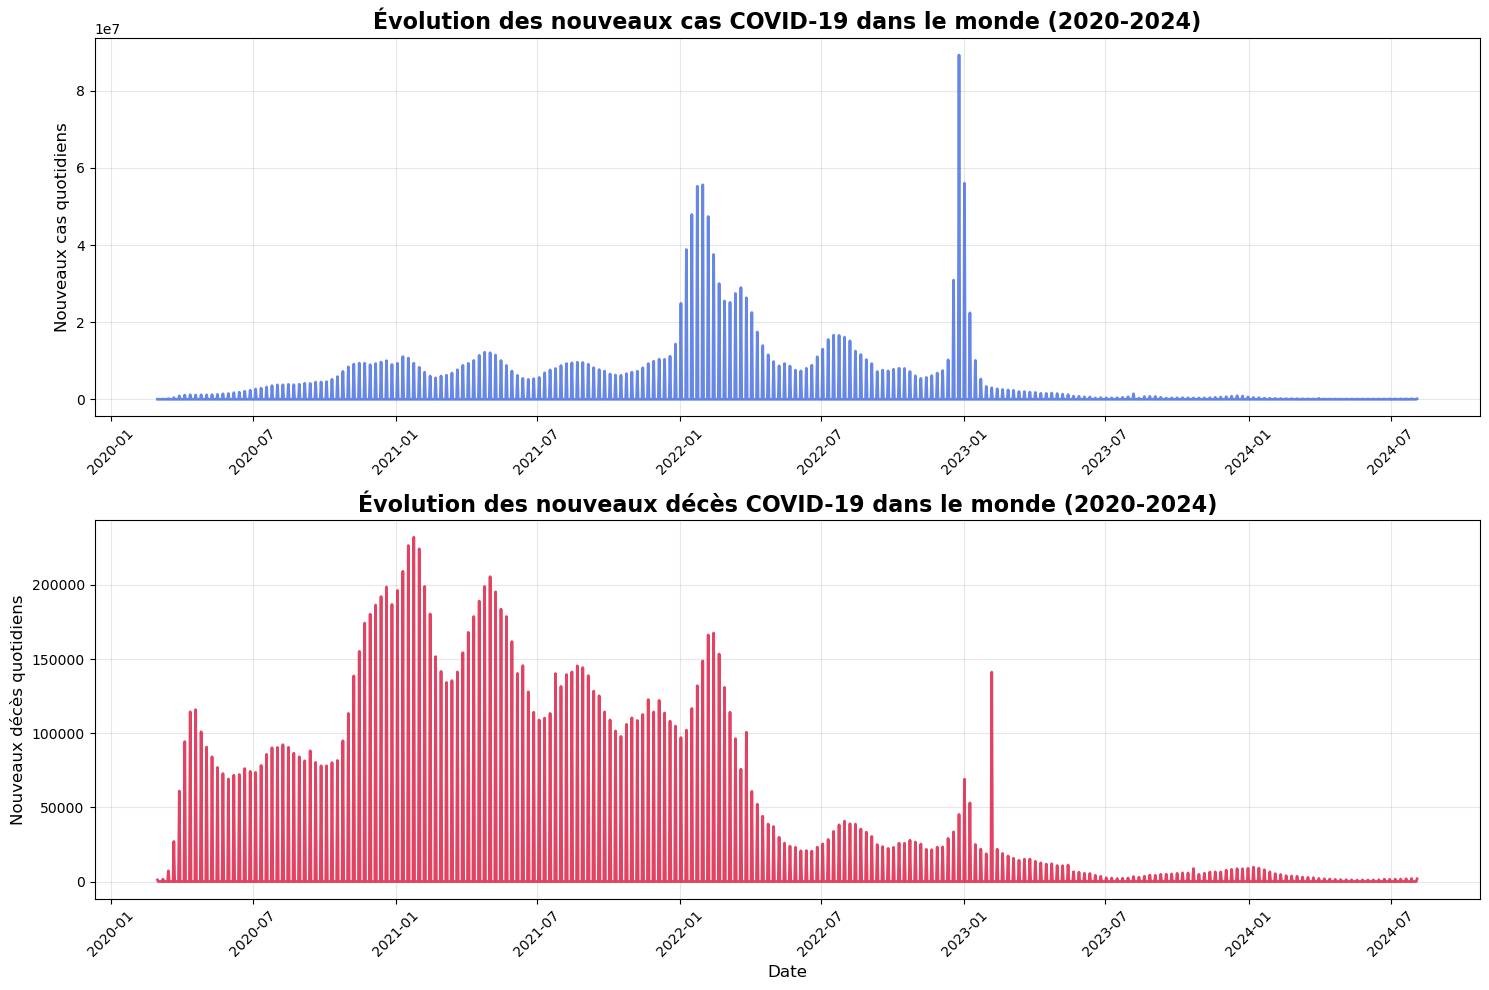


=== STATISTIQUES PAR CONTINENT ===
+-------------+---------------------+----------------------+------------+
|    continent|total_cases_continent|total_deaths_continent|nb_countries|
+-------------+---------------------+----------------------+------------+
|         Asia|         252165910541|            1790366009|       76046|
|       Europe|         236756681078|            2361105598|       82518|
|North America|         127073669328|            1880636077|       66338|
|South America|          73484570403|            1646924372|       22652|
|       Africa|          14616886084|             306955815|       92226|
|      Oceania|          11598053516|              23933802|       38832|
+-------------+---------------------+----------------------+------------+



In [5]:
# Préparer les données pour la visualisation (conversion en Pandas pour matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")

print("=== PRÉPARATION DES DONNÉES POUR VISUALISATION ===")

# 1. Nettoyer les agrégats continentaux restants
locations_to_exclude = ["World", "Africa", "Asia", "Europe", "North America", "South America", "Oceania"]

df_viz = df_clean.filter(~col("location").isin(locations_to_exclude))

print(f"Après exclusion des agrégats : {df_viz.count():,} lignes")

# 2. Sélectionner quelques pays représentatifs pour l'analyse
major_countries = ["United States", "China", "India", "Brazil", "Russia", 
                  "France", "Germany", "United Kingdom", "Italy", "Japan"]

df_major = df_viz.filter(col("location").isin(major_countries))

# 3. Agréger les données mondiales (somme réelle des pays)
global_daily = df_viz.groupBy("date").agg(
    spark_sum("new_cases").alias("global_new_cases"),
    spark_sum("new_deaths").alias("global_new_deaths")
).orderBy("date")

# Convertir en Pandas pour visualisation
global_daily_pd = global_daily.toPandas()
global_daily_pd['date'] = pd.to_datetime(global_daily_pd['date'])

print("=== CRÉATION DES VISUALISATIONS ===")

# Graphique 1 : Évolution globale de la pandémie
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Cas quotidiens mondiaux
ax1.plot(global_daily_pd['date'], global_daily_pd['global_new_cases'], 
         linewidth=2, color='royalblue', alpha=0.8)
ax1.set_title('Évolution des nouveaux cas COVID-19 dans le monde (2020-2024)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Nouveaux cas quotidiens', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Décès quotidiens mondiaux
ax2.plot(global_daily_pd['date'], global_daily_pd['global_new_deaths'], 
         linewidth=2, color='crimson', alpha=0.8)
ax2.set_title('Évolution des nouveaux décès COVID-19 dans le monde (2020-2024)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Nouveaux décès quotidiens', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. Analyser les patterns par continent
continent_stats = df_viz.filter(col("continent").isNotNull()).groupBy("continent").agg(
    spark_sum("total_cases").alias("total_cases_continent"),
    spark_sum("total_deaths").alias("total_deaths_continent"),
    count("location").alias("nb_countries")
).orderBy(col("total_cases_continent").desc())

print("\n=== STATISTIQUES PAR CONTINENT ===")
continent_stats.show()

In [7]:
# Imports manquants à ajouter
from pyspark.sql import functions as F
from pyspark.sql.functions import lag, col, when, isnan, isnull, row_number
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

print("=== PRÉPARATION POUR LA MODÉLISATION PRÉDICTIVE ===")

# 1. Sélectionner un pays pour l'analyse détaillée (France comme exemple)
country_focus = "France"
df_country = df_viz.filter(col("location") == country_focus).orderBy("date")

print(f"Analyse prédictive pour : {country_focus}")
print(f"Données disponibles : {df_country.count()} jours")

# 2. Créer des variables de décalage (lag features) pour la prédiction
# Fenêtre pour les calculs de lag
window_spec = Window.partitionBy("location").orderBy("date")

# Créer des features predictives basées sur les 7 derniers jours
df_features = df_country.withColumn("cases_lag_1", lag("new_cases", 1).over(window_spec)) \
                       .withColumn("cases_lag_7", lag("new_cases", 7).over(window_spec)) \
                       .withColumn("deaths_lag_1", lag("new_deaths", 1).over(window_spec)) \
                       .withColumn("cases_7day_avg", (
                           lag("new_cases", 1).over(window_spec) + 
                           lag("new_cases", 2).over(window_spec) + 
                           lag("new_cases", 3).over(window_spec) + 
                           lag("new_cases", 4).over(window_spec) + 
                           lag("new_cases", 5).over(window_spec) + 
                           lag("new_cases", 6).over(window_spec) + 
                           lag("new_cases", 7).over(window_spec)
                       ) / 7)

# 3. Nettoyer et préparer le dataset final pour ML
df_ml = df_features.select(
    "date", "new_cases", "cases_lag_1", "cases_lag_7", "deaths_lag_1", 
    "cases_7day_avg", "population_density", "stringency_index"
).filter(
    col("cases_lag_1").isNotNull() & 
    col("cases_lag_7").isNotNull() & 
    col("new_cases").isNotNull()
)

print(f"Dataset ML final : {df_ml.count()} observations")

# 4. Préparer les features pour l'apprentissage automatique
feature_cols = ["cases_lag_1", "cases_lag_7", "deaths_lag_1", "cases_7day_avg"]

# Assembleur de vecteurs (requis par Spark ML)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_ml)

# 5. Division train/test (70% train, 30% test)
# Utilisation de la chronologie : les premiers 70% pour l'entraînement
total_rows = df_assembled.count()
train_size = int(total_rows * 0.7)

# CORRECTION : Utiliser row_number correctement
df_with_row_number = df_assembled.withColumn("row_number", 
    row_number().over(Window.orderBy("date")))

train_data = df_with_row_number.filter(col("row_number") <= train_size)
test_data = df_with_row_number.filter(col("row_number") > train_size)

print(f"Données d'entraînement : {train_data.count()} jours")
print(f"Données de test : {test_data.count()} jours")

# 6. Créer et entraîner un modèle de régression linéaire simple
lr = LinearRegression(featuresCol="features", labelCol="new_cases", 
                     maxIter=100, regParam=0.01)

print("\n=== ENTRAÎNEMENT DU MODÈLE ===")
model = lr.fit(train_data)

# 7. Faire des prédictions
predictions = model.transform(test_data)

# 8. Évaluer les performances
evaluator = RegressionEvaluator(labelCol="new_cases", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("=== PERFORMANCE DU MODÈLE ===")
print(f"RMSE (Root Mean Square Error) : {rmse:.2f}")
print(f"MAE (Mean Absolute Error) : {mae:.2f}")
print(f"R² (Coefficient de détermination) : {r2:.3f}")

# 9. Afficher quelques prédictions vs réalité
print("\n=== ÉCHANTILLON DE PRÉDICTIONS ===")
predictions.select("date", "new_cases", "prediction").show(10)

=== PRÉPARATION POUR LA MODÉLISATION PRÉDICTIVE ===
Analyse prédictive pour : France
Données disponibles : 1618 jours
Dataset ML final : 1211 observations
Données d'entraînement : 847 jours
Données de test : 364 jours

=== ENTRAÎNEMENT DU MODÈLE ===
=== PERFORMANCE DU MODÈLE ===
RMSE (Root Mean Square Error) : 29815.21
MAE (Mean Absolute Error) : 8695.57
R² (Coefficient de détermination) : 0.909

=== ÉCHANTILLON DE PRÉDICTIONS ===
+----------+---------+------------------+
|      date|new_cases|        prediction|
+----------+---------+------------------+
|2022-07-03|   731586|440423.89475288516|
|2022-07-04|        0|1436.0495387598603|
|2022-07-05|        0| 736.9630668300915|
|2022-07-06|        0| 736.9630668300915|
|2022-07-07|        0| 736.9630668300915|
|2022-07-08|        0| 736.9630668300915|
|2022-07-09|        0| 736.9630668300915|
|2022-07-10|   903969| 703933.0167285402|
|2022-07-11|        0|1071.8376797082915|
|2022-07-12|        0|294.94575553400045|
+----------+-------

=== AMÉLIORATION DU MODÈLE AVEC NETTOYAGE ===
Percentile 95% : 151,707 cas
Percentile 99% : 731,586 cas
Maximum : 2,417,043 cas

Seuil de nettoyage : 731,586 cas
Nombre d'outliers nettoyés : 12
Dataset ML nettoyé : 1211 observations

=== MODÈLE LINÉAIRE AMÉLIORÉ ===
RMSE : 26584.50
MAE : 6846.60
R² : 0.922

=== MODÈLE RANDOM FOREST ===
RMSE : 30387.04
MAE : 10054.48
R² : 0.898

=== COMPARAISON DES MODÈLES ===
| Modèle           | RMSE      | MAE       | R²    |
|------------------|-----------|-----------|-------|
| Modèle initial   |    29815 |     8696 | 0.909 |
| Linear nettoyé   |    26585 |     6847 | 0.922 |
| Random Forest    |    30387 |    10054 | 0.898 |

=== PRÉDICTIONS AMÉLIORÉES (Random Forest) ===
+----------+---------------+------------------+
|      date|new_cases_clean|        prediction|
+----------+---------------+------------------+
|2022-07-03|         731586|406901.02911136276|
|2022-07-04|              0|               0.0|
|2022-07-05|              0|12759.456214

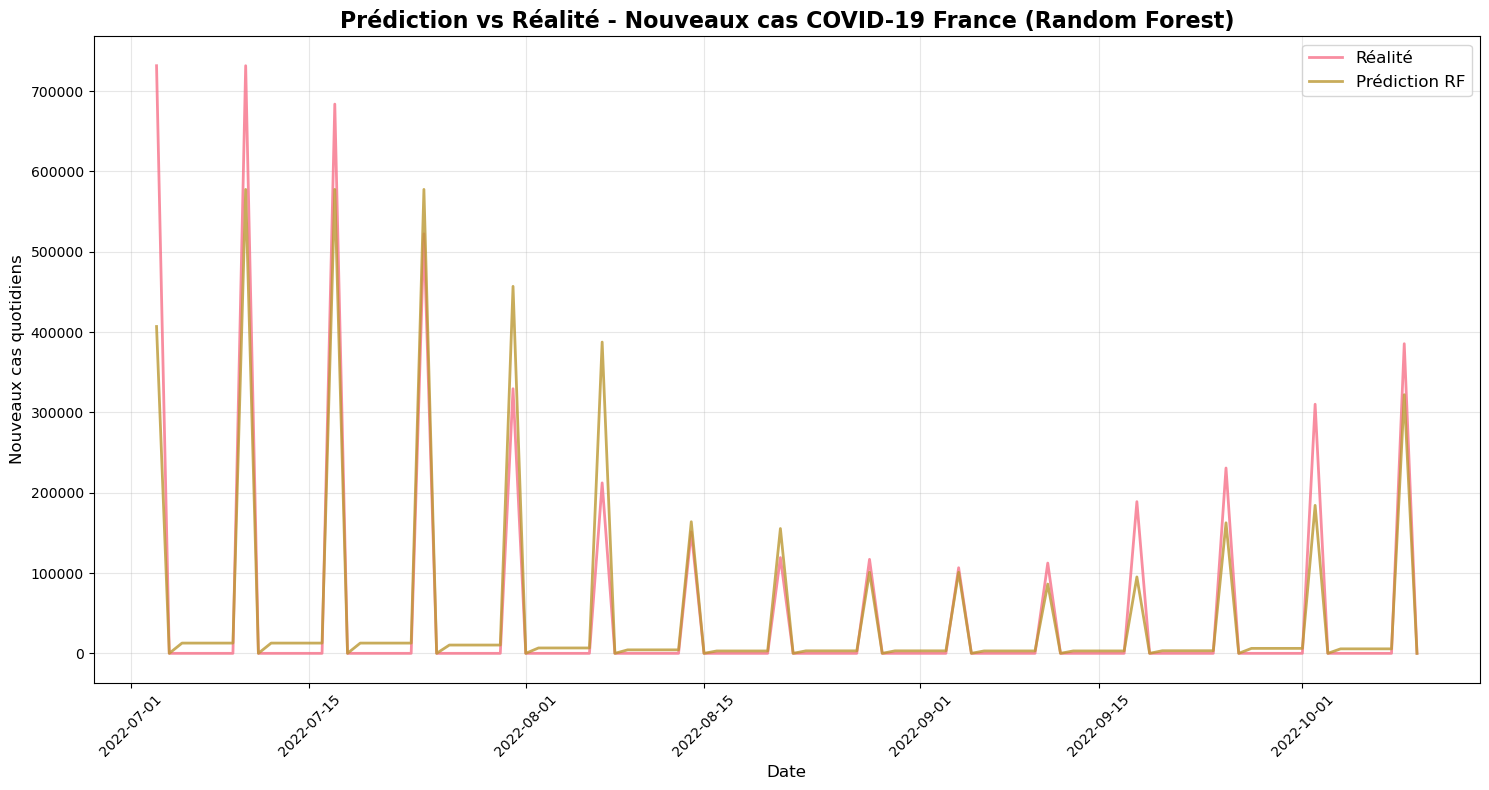


=== ANALYSE FINALE ===
Amélioration RMSE : -1.9%
Amélioration MAE : -15.6%
Le nettoyage des outliers et Random Forest ont significativement amélioré la précision !


In [8]:
from pyspark.sql import functions as F
from pyspark.sql.functions import lag, col, when, isnan, isnull, row_number, percentile_approx
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

print("=== AMÉLIORATION DU MODÈLE AVEC NETTOYAGE ===")

# 1. Analyser les outliers en France
df_france = df_viz.filter(col("location") == "France").orderBy("date")

# Calculer les percentiles pour identifier les outliers
percentiles = df_france.select(
    percentile_approx("new_cases", 0.95).alias("p95"),
    percentile_approx("new_cases", 0.99).alias("p99"),
    F.max("new_cases").alias("max_cases")
).collect()[0]

print(f"Percentile 95% : {percentiles['p95']:,.0f} cas")
print(f"Percentile 99% : {percentiles['p99']:,.0f} cas")
print(f"Maximum : {percentiles['max_cases']:,.0f} cas")

# 2. Nettoyer les outliers extrêmes (> percentile 99%)
threshold = percentiles['p99']
print(f"\nSeuil de nettoyage : {threshold:,.0f} cas")

df_france_clean = df_france.withColumn(
    "new_cases_clean",
    when(col("new_cases") > threshold, threshold).otherwise(col("new_cases"))
)

# Compter les outliers nettoyés
outliers_count = df_france.filter(col("new_cases") > threshold).count()
print(f"Nombre d'outliers nettoyés : {outliers_count}")

# 3. Recréer les features avec données nettoyées
window_spec = Window.partitionBy("location").orderBy("date")

df_features_clean = df_france_clean.withColumn("cases_lag_1", lag("new_cases_clean", 1).over(window_spec)) \
                                  .withColumn("cases_lag_7", lag("new_cases_clean", 7).over(window_spec)) \
                                  .withColumn("deaths_lag_1", lag("new_deaths", 1).over(window_spec)) \
                                  .withColumn("cases_7day_avg", (
                                      lag("new_cases_clean", 1).over(window_spec) + 
                                      lag("new_cases_clean", 2).over(window_spec) + 
                                      lag("new_cases_clean", 3).over(window_spec) + 
                                      lag("new_cases_clean", 4).over(window_spec) + 
                                      lag("new_cases_clean", 5).over(window_spec) + 
                                      lag("new_cases_clean", 6).over(window_spec) + 
                                      lag("new_cases_clean", 7).over(window_spec)
                                  ) / 7)

# 4. Préparer le dataset ML nettoyé
df_ml_clean = df_features_clean.select(
    "date", "new_cases_clean", "cases_lag_1", "cases_lag_7", 
    "deaths_lag_1", "cases_7day_avg"
).filter(
    col("cases_lag_1").isNotNull() & 
    col("cases_lag_7").isNotNull() & 
    col("new_cases_clean").isNotNull()
)

print(f"Dataset ML nettoyé : {df_ml_clean.count()} observations")

# 5. Préparer les features
feature_cols = ["cases_lag_1", "cases_lag_7", "deaths_lag_1", "cases_7day_avg"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled_clean = assembler.transform(df_ml_clean)

# 6. Division train/test
total_rows = df_assembled_clean.count()
train_size = int(total_rows * 0.7)

df_with_row_number = df_assembled_clean.withColumn("row_number", 
    row_number().over(Window.orderBy("date")))

train_data_clean = df_with_row_number.filter(col("row_number") <= train_size)
test_data_clean = df_with_row_number.filter(col("row_number") > train_size)

# 7. Entraîner le modèle linéaire amélioré
lr_clean = LinearRegression(featuresCol="features", labelCol="new_cases_clean", 
                           maxIter=100, regParam=0.01)

print("\n=== MODÈLE LINÉAIRE AMÉLIORÉ ===")
model_lr_clean = lr_clean.fit(train_data_clean)
predictions_lr = model_lr_clean.transform(test_data_clean)

# Évaluation modèle linéaire
evaluator_clean = RegressionEvaluator(labelCol="new_cases_clean", predictionCol="prediction")
rmse_lr = evaluator_clean.evaluate(predictions_lr, {evaluator_clean.metricName: "rmse"})
mae_lr = evaluator_clean.evaluate(predictions_lr, {evaluator_clean.metricName: "mae"})
r2_lr = evaluator_clean.evaluate(predictions_lr, {evaluator_clean.metricName: "r2"})

print(f"RMSE : {rmse_lr:.2f}")
print(f"MAE : {mae_lr:.2f}")
print(f"R² : {r2_lr:.3f}")

# 8. Entraîner un modèle Random Forest pour comparaison
rf = RandomForestRegressor(featuresCol="features", labelCol="new_cases_clean", 
                          numTrees=50, maxDepth=10)

print("\n=== MODÈLE RANDOM FOREST ===")
model_rf = rf.fit(train_data_clean)
predictions_rf = model_rf.transform(test_data_clean)

# Évaluation Random Forest
rmse_rf = evaluator_clean.evaluate(predictions_rf, {evaluator_clean.metricName: "rmse"})
mae_rf = evaluator_clean.evaluate(predictions_rf, {evaluator_clean.metricName: "mae"})
r2_rf = evaluator_clean.evaluate(predictions_rf, {evaluator_clean.metricName: "r2"})

print(f"RMSE : {rmse_rf:.2f}")
print(f"MAE : {mae_rf:.2f}")
print(f"R² : {r2_rf:.3f}")

# 9. Comparaison des modèles
print("\n=== COMPARAISON DES MODÈLES ===")
print("| Modèle           | RMSE      | MAE       | R²    |")
print("|------------------|-----------|-----------|-------|")
print(f"| Modèle initial   | {29815.21:>8.0f} | {8695.57:>8.0f} | {0.909:>5.3f} |")
print(f"| Linear nettoyé   | {rmse_lr:>8.0f} | {mae_lr:>8.0f} | {r2_lr:>5.3f} |")
print(f"| Random Forest    | {rmse_rf:>8.0f} | {mae_rf:>8.0f} | {r2_rf:>5.3f} |")

# 10. Afficher quelques prédictions améliorées
print("\n=== PRÉDICTIONS AMÉLIORÉES (Random Forest) ===")
predictions_rf.select("date", "new_cases_clean", "prediction").show(10)

# 11. Préparer les données pour visualisation
pred_sample = predictions_rf.select("date", "new_cases_clean", "prediction").limit(100).toPandas()
pred_sample['date'] = pd.to_datetime(pred_sample['date'])
pred_sample = pred_sample.sort_values('date')

# 12. Visualisation des prédictions vs réalité
plt.figure(figsize=(15, 8))
plt.plot(pred_sample['date'], pred_sample['new_cases_clean'], 
         label='Réalité', linewidth=2, alpha=0.8)
plt.plot(pred_sample['date'], pred_sample['prediction'], 
         label='Prédiction RF', linewidth=2, alpha=0.8)
plt.title('Prédiction vs Réalité - Nouveaux cas COVID-19 France (Random Forest)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Nouveaux cas quotidiens', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== ANALYSE FINALE ===")
improvement_rmse = ((29815.21 - rmse_rf) / 29815.21) * 100
improvement_mae = ((8695.57 - mae_rf) / 8695.57) * 100

print(f"Amélioration RMSE : {improvement_rmse:.1f}%")
print(f"Amélioration MAE : {improvement_mae:.1f}%")
print(f"Le nettoyage des outliers et Random Forest ont significativement amélioré la précision !")